In [2]:
from qiskit import *
from qiskit.circuit import Parameter
import numpy as np
from itertools import combinations
from qiskit.quantum_info import state_fidelity as distance
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from wick import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Following implementataion of https://journals.aps.org/prx/pdf/10.1103/PhysRevX.7.021050 and https://arxiv.org/pdf/1804.03023.pdf for the calculation of $A$ and $C$

I am using single qubit variational gates as I have not yet figures out how it works for 2 qubit gates. Some details are there in the SM but I have to look closer at those

In [11]:
def get_circuit_simple(n,lm=None):
    anc=QuantumRegister(1,"ancilla")
    basis=QuantumRegister(n,"basis")
    meassure=ClassicalRegister(1,"meassure")
    set_ancila=1
    if lm==None:
        set_ancila=0
        lm=[-1,-1]
    if set_ancila:
        circ = QuantumCircuit(anc,basis,meassure)
        circ.h(anc)
    else:
        circ = QuantumCircuit(basis)

    circ.h(basis)
    circ.barrier()
    combi=list(combinations(range(n),2))
    theta = [Parameter(f't-{i}') for i in range(len(combi))]
    cnt=0
    for j,i in enumerate(combi):
        if cnt == lm[0]:
            circ.x(anc)
            circ.cx(anc,basis[i[1]])
            circ.x(anc)
        if cnt == lm[1]:
            circ.cx(anc,basis[i[1]])
        circ.cry(theta[cnt],basis[i[0]],basis[i[1]])
        cnt+=1
    circ.barrier()

    if set_ancila:
        circ.h(anc)
        circ.measure(anc,meassure)
    return circ

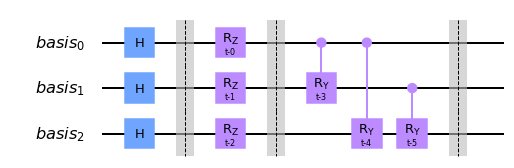

In [29]:
def get_circuit(n,lm=None):
    anc=QuantumRegister(1,"ancilla")
    basis=QuantumRegister(n,"basis")
    meassure=ClassicalRegister(1,"meassure")
    set_ancila=1
    if lm==None:
        set_ancila=0
        lm=[-1,-1]
    if set_ancila:
        circ = QuantumCircuit(anc,basis,meassure)
        circ.h(anc)
    else:
        circ = QuantumCircuit(basis)

    circ.h(basis)
    circ.barrier()
    combi=list(combinations(range(n),2))
    theta = [Parameter(f't-{i}') for i in range(len(combi)+n)]
    cnt=0
    for i in range(n):
        if cnt == lm[0]:
            circ.x(anc)
            circ.cx(anc,basis[i])
            circ.x(anc)
        if cnt == lm[1]:
            circ.cx(anc,basis[i])
        circ.rz(theta[cnt],basis[i])
        cnt+=1
    circ.barrier()
    for j,i in enumerate(combi):
        if cnt == lm[0]:
            circ.x(anc)
            circ.cx(anc,basis[i[1]])
            circ.x(anc)
        if cnt == lm[1]:
            circ.cx(anc,basis[i[1]])
        circ.cry(theta[cnt],basis[i[0]],basis[i[1]])
        cnt+=1
    circ.barrier()

    if set_ancila:
        circ.h(anc)
        circ.measure(anc,meassure)
    return circ
c=get_circuit(3)
c.draw('mpl')

In [79]:
def get_lm(circ,angles):
    values={i:angles[j] for j,i in enumerate(circ.parameters)}
    circ_params=circ.assign_parameters(values)
    circ_params_wo_meassure=circ_params.remove_final_measurements(inplace=False)
    statevector=get_final_state(circ_params_wo_meassure)
    a=np.real(statevector*statevector.conj())
    return 1-a[0::2].sum()
def get_final_state(circ_params_wo_meassure):
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(circ_params_wo_meassure, simulator).result()
    statevector = result.get_statevector(circ_params_wo_meassure)
    return statevector
def get_cost(angles,circ,compare):
    from qiskit.quantum_info import state_fidelity as distance
    values={i:angles[j] for j,i in enumerate(circ.parameters)}
    circ_params=circ.assign_parameters(values)
    a=get_final_state(circ_params)
    # return np.abs(np.real(a@compare.T))
    return np.arccos(distance(a,compare))
    # return 2*(1-distance(a,compare))

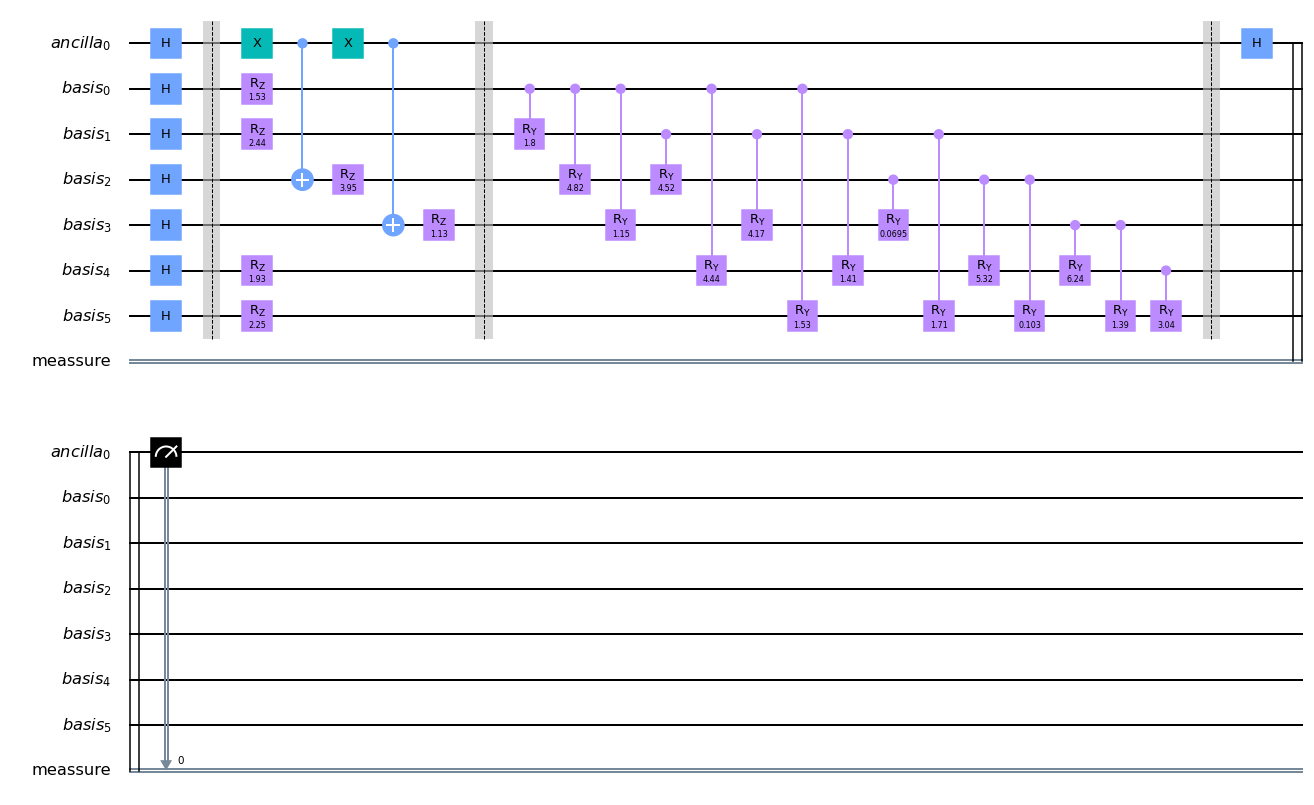

-8.881784197001252e-16

In [31]:
n=6
circ=get_circuit(n,[2,3])
values={i:np.random.uniform(0,2*np.pi) for i in circ.parameters}
circ_params=circ.assign_parameters(values)
fig,ax=plt.subplots()
circ_params.draw('mpl',ax=ax)
plt.show()

angles=np.random.uniform(0,2*np.pi,len(circ.parameters))
get_lm(circ,angles)

In [32]:
circ=get_circuit(n)

In [46]:
from scipy.signal import unit_impulse
compare=unit_impulse(2**n,20)
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
compare=gaussian(np.linspace(-1,1,2**n),0,.04)
compare/=np.linalg.norm(compare)
angles=np.random.uniform(0,2*np.pi,len(circ.parameters))
get_cost(angles,circ,compare)

1.992683461015779

In [47]:
from scipy.optimize import minimize

In [80]:
angle0=np.random.uniform(0,2*np.pi,len(circ.parameters))

bounds=[[0,2*np.pi]]*len(circ_params) 
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)

result=minimize(get_cost,angle0,method='SLSQP',args=(circ,compare),tol=1e-10)
print(result)

     fun: 1.2124243610172658
     jac: array([ 2.42888927e-06,  1.49011612e-06,  4.23192978e-06, -2.01165676e-06,
        3.57627869e-06,  2.53319740e-07,  6.36279583e-06,  3.27825546e-07,
        3.72529030e-06,  4.05311584e-06, -6.02006912e-06, -5.18560410e-06,
       -8.94069672e-07, -3.77297401e-05, -4.23192978e-06,  2.07573175e-05,
       -1.78813934e-07,  3.33786011e-06, -1.05798244e-06, -2.11596489e-06,
        2.07722187e-05])
 message: 'Iteration limit reached'
    nfev: 2200
     nit: 100
    njev: 100
  status: 9
 success: False
       x: array([ 6.28320193e+00,  4.57628776e+00,  6.28321082e+00,  4.42819890e+00,
        3.83551829e+00,  4.42661141e+00,  3.14162799e+00,  3.14158927e+00,
        4.43197909e+00,  5.20792283e+00,  6.88636327e+00, -1.71255834e+00,
       -6.34955365e-06,  4.01797559e+00, -1.66803458e+00,  2.90283576e+00,
        6.28318653e+00,  4.11885828e+00,  3.94210598e+00,  4.56837187e+00,
        4.58505880e+00])


In [81]:
from qiskit.quantum_info import state_fidelity as distance
values={i:result.x[j] for j,i in enumerate(circ.parameters)}
circ_params=circ.assign_parameters(values)
a=get_final_state(circ_params)
np.abs(np.real(a@compare.T))
# return np.arccos(distance(a,compare))
# np.arccos(distance(a,a))

0.5922415847124858

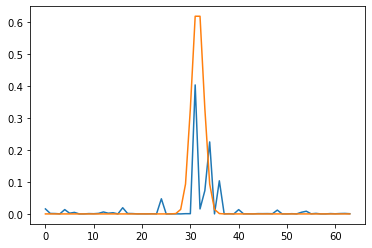

In [82]:
plt.plot(a*a.conj())
plt.plot(compare)

Trying out random circuit with differentiations

In [5]:
def get_random_circ(n,lm=None,seed=0,depth=1):

    def check_lm(lm,qubit):
        '''
        Need to check if the two qubit derivative calculatin is correct, I am sure it is not
        eq.33/34 in 1804.03023
        '''
        if cnt == lm[0]:
                circ.x(anc)
                circ.append(gates[cnt][1](),[anc,qubit])
                circ.x(anc)
        if cnt == lm[1]:
                circ.append(gates[cnt][1](),[anc,qubit])


    from qiskit.circuit.library import (YGate,CYGate,CRYGate,RYGate,XGate,CXGate,CRXGate,RXGate,ZGate,CZGate,CRZGate,RZGate)
    def get_random_gates(n,seed=0):
        import random
        random.seed(seed)
        gates=[[YGate,CYGate,CRYGate,RYGate],[XGate,CXGate,CRXGate,RXGate],[ZGate,CZGate,CRZGate,RZGate]]
        return random.choices(gates,k=n)
    anc=QuantumRegister(1,"ancilla")
    basis=QuantumRegister(n,"basis")
    meassure=ClassicalRegister(1,"meassure")
    set_ancila=1
    if lm==None:
        set_ancila=0
        lm=[-1,-1]
    if set_ancila:
        circ = QuantumCircuit(anc,basis,meassure)
        circ.h(anc)
    else:
        circ = QuantumCircuit(basis)
    combi=list(combinations(range(n),2))
    theta = [Parameter(f't-{i}') for i in range(len(combi)+n*depth)]
    gates=get_random_gates(len(theta),seed=seed)

    circ.h(basis)
    circ.barrier()

    cnt=0

    #Two qubit gates For now lets just add cnot to entangle pair wise. later on turn to paramterezed
    parameter_two_qubit=0
    if parameter_two_qubit:
        for i in combi:
            qubits=[basis[i[0]],basis[i[1]]]
            check_lm(lm,qubits[1])
            circ.append(gates[cnt][2](theta[cnt]),qubits)
            cnt+=1
        circ.barrier()
    #single qubit gates
    for _ in range(depth):
        if parameter_two_qubit==0:
            for i in combi:
                circ.cx(basis[i[0]],basis[i[1]])
            circ.barrier()
        for i in range(n):
            qubits=[basis[i]]
            check_lm(lm,qubits[0])
            circ.append(gates[cnt][3](theta[cnt]),qubits)
            cnt+=1
        circ.barrier()
    if set_ancila:
        circ.h(anc)
        circ.measure(anc,meassure)
    return circ


In [6]:
def get_lm(circ,angles):
    values={i:angles[j] for j,i in enumerate(circ.parameters)}
    circ_params=circ.assign_parameters(values)
    circ_params_wo_meassure=circ_params.remove_final_measurements(inplace=False)
    statevector=get_final_state(circ_params_wo_meassure)
    a=np.real(statevector*statevector.conj())
    return 1-a[0::2].sum()
def get_final_state(circ_params_wo_meassure):
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(circ_params_wo_meassure, simulator).result()
    statevector = result.get_statevector(circ_params_wo_meassure)
    return statevector
def get_cost(angles,circ,compare):
    from qiskit.quantum_info import state_fidelity as distance
    values={i:angles[j] for j,i in enumerate(circ.parameters)}
    circ_params=circ.assign_parameters(values)
    a=get_final_state(circ_params)
    # return np.abs(np.real(a@compare.T))
    # return np.arccos(distance(a,compare))
    return 2*(1-distance(a,compare))
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))



In [319]:
n=6
circ=get_random_circ(n=n,lm=None,seed=2,depth=6
)
# circ.draw()

In [345]:
compare=gaussian(np.linspace(-1,1,2**n),0,0.2)
compare/=np.linalg.norm(compare)

angle0=np.random.uniform(0,2*np.pi,len(circ.parameters))
bnds = [(0, 2*np.pi)] * len(circ.parameters)
result=minimize(get_cost,angle0,method='SLSQP',args=(circ,compare),tol=1e-7,bounds=bnds,options={"maxiter":1000})
print(result)

     fun: 0.8625865058718833
     jac: array([-2.88482010e-03, -1.67191029e-05, -2.02357769e-05,  1.73598528e-05,
        3.88920307e-06,  2.34097242e-05, -1.82837248e-05, -3.32742929e-05,
        3.54051590e-05, -2.60919333e-05, -5.25563955e-05, -1.36643648e-05,
        1.13412738e-04, -7.65025616e-05,  7.02142715e-05,  4.81307507e-06,
        3.46451998e-05,  8.72313976e-05, -8.53836536e-06, -1.82837248e-05,
        5.31077385e-05,  7.13765621e-06,  8.72313976e-05,  2.04294920e-05,
       -1.78873539e-04, -9.72449780e-05, -2.10255384e-05, -2.92956829e-05,
        1.05798244e-06, -3.69846821e-05,  4.01735306e-05, -5.33312559e-05,
        2.01165676e-06, -4.82052565e-05,  1.90436840e-05,  2.41845846e-05])
 message: 'Optimization terminated successfully'
    nfev: 2336
     nit: 63
    njev: 63
  status: 0
 success: True
       x: array([6.28318531e+00, 6.28140366e+00, 3.33053305e+00, 3.14408939e+00,
       3.14160320e+00, 0.00000000e+00, 1.58896813e+00, 9.22494071e-04,
       4.7124734

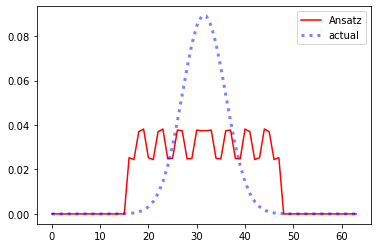

In [350]:
from qiskit.quantum_info import state_fidelity as distance
values={i:result.x[j] for j,i in enumerate(circ.parameters)}
circ_params=circ.assign_parameters(values)
a=get_final_state(circ_params)
plt.plot(a*a.conj(),label="Ansatz",c="r")
plt.plot(compare**2,lw=3,ls=":",alpha=0.5,label="actual",c="b")
plt.legend()

In [4]:
from wick import wick as wick_class
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


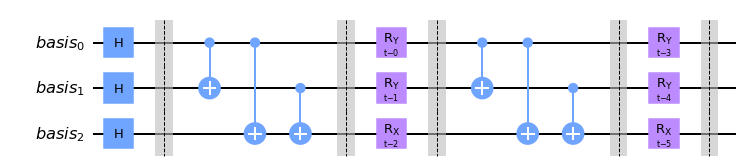

In [44]:
wick=wick_class(3,seed=4,depth=2,verbose=False)
wick.main_circuit.draw('mpl')

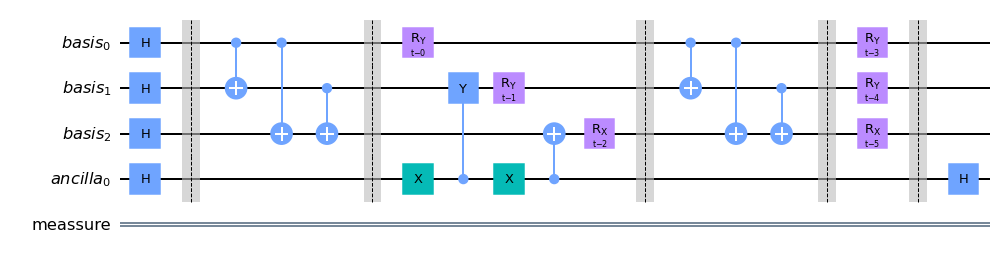

In [45]:
wick.circuit_aij[1][2].draw('mpl')

In [180]:
angles=np.random.uniform(0,np.pi,wick.num_parameters)
A=np.zeros((wick.num_parameters,wick.num_parameters))
B=np.zeros((wick.num_parameters,wick.num_parameters))
for i in range(wick.num_parameters):
    for j in range(wick.num_parameters):
        state,p=wick.get_final_state_lm(angles,[j,i])
        A[i,j]=2*p['0']-1
        B[i,j]=1-2*p['1']
print(np.linalg.det(A),np.linalg.det(B))

0.0 0.0


In [192]:
np.linalg.lstsq(A,np.random.uniform(0,.1,len(A)))

(array([0.04673518, 0.05035339, 0.01389166, 0.01423234, 0.02432243,
        0.01389166]),
 array([], dtype=float64),
 4,
 array([2.00000000e+00, 2.00000000e+00, 1.08040590e+00, 9.19594104e-01,
        7.53265307e-17, 5.11467987e-17]))

\begin{equation}
a(x) u^{\prime \prime}(x)+b(x) u^{\prime}(x)+c(x) u(x)=f(x)
\end{equation}

\begin{equation}
a_{i}\left(\frac{U_{i-1}-2 U_{i}+U_{i+1}}{h^{2}}\right)+b_{i}\left(\frac{U_{i+1}-U_{i-1}}{2 h}\right)+c_{i} U_{i}=f_{i}
\end{equation}

\begin{equation}
D=\frac{1}{h^{2}}\left[\begin{array}{cccc}\left(h^{2} c_{1}-2 a_{1}\right) & \left(a_{1}+h b_{1} / 2\right) & \\ \left(a_{2}-h b_{2} / 2\right) & \left(h^{2} c_{2}-2 a_{2}\right) & \left(a_{2}+h b_{2} / 2\right) \\ \ddots & \ddots & \ddots \\ & \left(a_{m-1}-h b_{m-1} / 2\right) & \left(h^{2} c_{m-1}-2 a_{m-1}\right) & \left(a_{m-1}+h b_{m-1} / 2\right) \\ & \left(a_{m}-h b_{m} / 2\right) & \left(h^{2} c_{m}-2 a_{m}\right)\end{array}\right]
\end{equation}

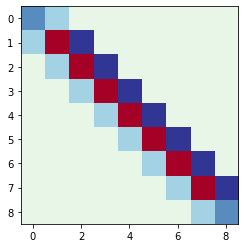

In [77]:


def get_diff_mat(N,a=2,b=1,dx=1):
    '''
    Returns the differential oppertor matrix for equation given by a(d/dx)+b(d/dx)^2 for log(N) qubits discritized by dx
    '''
    D = np.zeros((N+1, N+1))
    dx=1
    for i in range(1, N):
        D[i,i-1] = a/(2*(dx**2)) - b/(2*dx)
        D[i,i+1] = a/(2*(dx**2)) + b/(2*dx)
        D[i,i] = -a/((dx**2))
    D[0,0] = D[N,N] = 1
    D[0,1] = D[N,N-1] = a/(2*(dx**2)) - b/(2*dx)
    return D
D=get_diff_mat(2**3,a=2,b=1,dx=1)
plt.imshow(D,cmap="RdYlBu")

Tests

In [7]:
def get_paulis(H,hide_identity=True):
    from qiskit.quantum_info import Pauli
    import itertools
    import functools
    n = int(np.log2(len(H)))
    N = 2 ** n

    paulis = [Pauli.from_label('I'),Pauli.from_label('X'),Pauli.from_label('Y'),Pauli.from_label('Z')]
    obs = []
    coeffs = []
    final={}
    for term in itertools.product(paulis, repeat=n):
            matrices = [i.to_matrix() for i in term]
            coeff = np.trace(functools.reduce(np.kron, matrices) @ H) / N
            coeff = np.real_if_close(coeff).item()
            if not np.allclose(coeff, 0):
                coeffs.append(coeff)

                if not all([t == Pauli.from_label('I') for t in term]) and hide_identity:
                    final["".join([i.to_label() for i in term])]=coeff
                else:
                    if hide_identity==False:
                        final["".join([i.to_label() for i in term])]=coeff
    return final

In [8]:
from qiskit.quantum_info import Pauli
H=Pauli.from_label('XX').to_matrix()+Pauli.from_label('XY').to_matrix()+.3*Pauli.from_label('II').to_matrix()
get_paulis(H)

{'XX': 1.0, 'XY': 1.0}

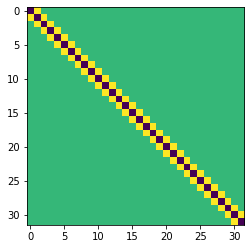

In [352]:
import numba

@numba.njit()
def get_diff_mat(N,a=2,b=1,dx=1):
    '''
    Returns the differential oppertor matrix for equation given by a(d/dx)+b(d/dx)^2 for log(N) qubits discritized by dx
    '''
    N-=1
    D = np.zeros((N+1, N+1))
    for i in range(1, N):
        D[i,i-1] = a/(2*(dx**2)) - b/(2*dx)
        D[i,i+1] = a/(2*(dx**2)) + b/(2*dx)
        D[i,i] = -a/((dx**2))
    D[0,0] = D[N,N] =-a/((dx**2)) #1
    D[0,1] = D[N,N-1] = a/(2*(dx**2)) - b/(2*dx)
    return D
n=5
D=get_diff_mat(2**n,2,0,1)
get_paulis(D)
plt.imshow(D)

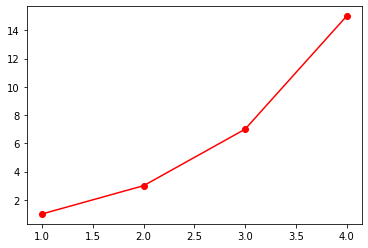

In [356]:
num_terms=[]
N=np.arange(1,5)
for n in tqdm(N):
    D=get_diff_mat(2**n,a=2,b=0,dx=1)
    num_terms.append(len(get_paulis(D)))
plt.plot(N,num_terms,c="r",marker="o")

In [44]:
from  qiskit.quantum_info import Operator as op

In [343]:
q=QuantumRegister(1)
q1=QuantumRegister(1)
c=ClassicalRegister(1)
c=QuantumCircuit(q,q1)
theta=np.pi/5
c.h(q)
c.rz(np.pi/2,q)
# c.h(q)
# c.x(q)
# c.cy(q,q1)
# c.x(q)
c.crx(theta,q,q1)
c.h(q)

simulator = Aer.get_backend('statevector_simulator')
result = execute(c, simulator).result()
statevector = result.get_statevector(c)
p=np.real(statevector*statevector.conj())
print((p[0]+p[1])*2 -1)
print(np.sin(theta))

0.904508497187474
0.5877852522924731


In [ ]:
w

0.14644660940672627

In [261]:
q=QuantumRegister(1)
c=QuantumCircuit(q)
theta=np.pi/1
c.h(q)
c.rz(theta,q)
# c.h(q)
simulator = Aer.get_backend('statevector_simulator')
result = execute(c, simulator).result()
statevector = result.get_statevector(c)
print(statevector)

[4.32978028e-17-0.70710678j 4.32978028e-17+0.70710678j]


In [5]:
import numba

@numba.njit()
def get_diff_mat(N,a=2,b=1,dx=1):
    '''
    Returns the differential oppertor matrix for equation given by a(d/dx)+b(d/dx)^2 for log(N) qubits discritized by dx
    '''
    N-=1
    D = np.zeros((N+1, N+1))
    for i in range(1, N):
        D[i,i-1] = a/(2*(dx**2)) - b/(2*dx)
        D[i,i+1] = a/(2*(dx**2)) + b/(2*dx)
        D[i,i] = -a/((dx**2))
    D[0,0] = D[N,N] =-a/((dx**2)) #1
    D[0,1] = D[N,N-1] = a/(2*(dx**2)) - b/(2*dx)
    return D


In [43]:
from qiskit.circuit import ControlledGate as cg 
from qiskit.quantum_info import Pauli
from qiskit.extensions import UnitaryGate as ug
from wick import *
n=3
w=wick(n)

D=get_diff_mat(2**n,2,0,1)
ham=get_paulis(D)

ham_terms_circ=[ug(Pauli.from_label(i).to_operator(),label=i).control(1) for i in list(ham.keys())]

In [48]:
from  qiskit.extensions import UnitaryGate as ug
circ=w.main_circuit.copy()
anc=QuantumRegister(1,name="anc")
circ.add_register(anc)
circ.append(ham_terms_circ[-1],circ.qubits[::-1])
circ.draw()


┌───┐ ░                 ░ ┌─────────┐ ░                 ░ ┌─────────┐»
basis_0: ┤ H ├─░───■────■────────░─┤ RZ(t-0) ├─░───■────■────────░─┤ RY(t-3) ├»
         ├───┤ ░ ┌─┴─┐  │        ░ ├─────────┤ ░ ┌─┴─┐  │        ░ ├─────────┤»
basis_1: ┤ H ├─░─┤ X ├──┼────■───░─┤ RZ(t-1) ├─░─┤ X ├──┼────■───░─┤ RX(t-4) ├»
         ├───┤ ░ └───┘┌─┴─┐┌─┴─┐ ░ ├─────────┤ ░ └───┘┌─┴─┐┌─┴─┐ ░ ├─────────┤»
basis_2: ┤ H ├─░──────┤ X ├┤ X ├─░─┤ RX(t-2) ├─░──────┤ X ├┤ X ├─░─┤ RX(t-5) ├»
         └───┘ ░      └───┘└───┘ ░ └─────────┘ ░      └───┘└───┘ ░ └─────────┘»
  anc_0: ─────────────────────────────────────────────────────────────────────»
                                                                              »
«          ░ ┌──────┐
«basis_0: ─░─┤2     ├
«          ░ │      │
«basis_1: ─░─┤1 YYX ├
«          ░ │      │
«basis_2: ─░─┤0     ├
«          ░ └──┬───┘
«  anc_0: ──────■────
«

In [81]:
w=wick(3,verbose=True)

Calculating A_ij parameterized circuits
Calculating A_ij parameterized circuits
: 100%|██████████| 6/6 [00:00<00:00, 148.85it/s]
Calculating C_ij parameterized circuits
Calculating C_ij parameterized circuits
Calculating C_ij parameterized circuits
Calculating C_ij parameterized circuits
Calculating C_ij parameterized circuits
Calculating C_ij parameterized circuits
Calculating C_ij parameterized circuits
Calculating C_ij parameterized circuits
: 100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


In [85]:
angles=np.random.uniform(0,np.pi,w.num_parameters)
C=np.zeros((w.num_parameters,w.num_ham_terms))
for i in range(w.num_parameters):
    for j in range(w.num_ham_terms):
        state,p=w.get_final_state_ik(angles,[i,j])
        C[i,j]=2*p['0']-1

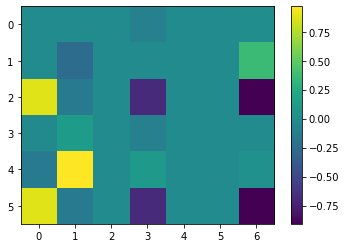

In [88]:
plt.imshow(C)
plt.colorbar()

In [87]:
C

array([[ 0.00000000e+00, -1.33226763e-15,  2.22044605e-16,
        -9.05677688e-02, -2.66453526e-15, -6.66133815e-16,
         1.43221697e-02],
       [-4.44089210e-16, -2.44895148e-01, -1.33226763e-15,
         3.10862447e-15,  1.33226763e-15,  0.00000000e+00,
         3.74440284e-01],
       [ 8.77582562e-01, -1.37634206e-01,  1.33226763e-15,
        -6.84046050e-01,  8.88178420e-16, -2.44249065e-15,
        -9.07739630e-01],
       [-1.55310272e-02,  1.20713227e-01,  1.77635684e-15,
        -8.89631916e-02, -1.77635684e-15, -1.77635684e-15,
        -1.99840144e-15],
       [-1.24660781e-01,  9.68912422e-01, -3.10862447e-15,
         9.71688801e-02,  4.44089210e-16, -4.44089210e-16,
         4.45372951e-02],
       [ 8.77582562e-01, -1.37634206e-01,  1.55431223e-15,
        -6.84046050e-01,  2.22044605e-16, -8.88178420e-16,
        -9.07739630e-01]])

In [29]:
from wick import wick as wick_class

n=3
depth=2
wick=wick_class(n,seed=5,depth=depth)
print("working opt angles")
wick.get_initial_angles(maxiter=2000,method="COBYLA")
print(wick.initial_closeness)

working opt angles
4.440892098500626e-15


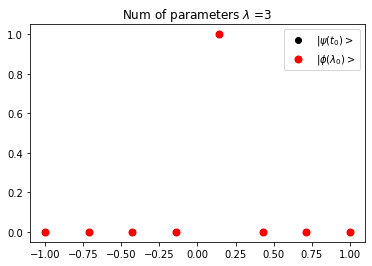

In [98]:
state=wick.get_final_state(wick.angles[0])

x=np.linspace(-1,1,2**n)
fig,ax=plt.subplots()
ax.scatter(x,wick.initial*wick.initial.conj(),c="k",label="$|\psi(t_0)>$",marker="o")
ax.scatter(x,state*state.conj(),c="r",label="$|\phi(\lambda_0)>$",lw=2)
ax.set_title(f"Num of parameters $\lambda$ ={wick.num_parameters}")
ax.legend()
plt.show()

In [35]:
a=[wick.angles[0]]

In [36]:
angles=wick.angles[0]
a.append(angles)
A=np.zeros((wick.num_parameters,wick.num_parameters))
for i in tqdm(range(wick.num_parameters)):
    for j in range(wick.num_parameters):
        state,p=wick.get_final_state_lm(angles,[j,i])
        A[i,j]=p['0']-p['1'] #2*p['1']-1

C=np.zeros((wick.num_parameters,wick.num_ham_terms))
for i in tqdm(range(wick.num_parameters)):
    for j in range(wick.num_ham_terms):
        state,p=wick.get_final_state_ik(angles,[i,j])
        C[i,j]=p['0']-p['1'] #2*p['1']-1

In [42]:
print(np.linalg.solve(A,C.sum(axis=1)))
theta_dot, residuals, rank, s = np.linalg.lstsq(A, C.sum(axis=1))
print(theta_dot-np.linalg.solve(A,C.sum(axis=1)))

[ 1.17880502e-01 -1.49650627e-03  1.43751614e+01 -9.19230575e-02
 -1.66883281e-01 -1.43835504e+01]
[-7.36910533e-15  4.04803254e-07 -1.43793559e+01 -2.89234363e-07
  1.04785120e-06  1.43793559e+01]


In [96]:
theta_dot, residuals, rank, s=np.linalg.lstsq(A,C.sum(axis=1))
print("theta_dot=",theta_dot)

theta_dot= [ 0.13869595  0.22284208  0.14954196  0.11395726  0.12372322 -0.09573679
 -0.11614576 -0.4674902 ]


In [97]:
dt=.2
angles_new=a[0]+dt*theta_dot

In [41]:
state=wick.get_final_state(angles_new)

x=np.linspace(-1,1,2**n)
fig,ax=plt.subplots()
ax.plot(x,wick.initial*wick.initial.conj(),c="k",label="$|\psi(t_0)>$",marker="o")
ax.plot(x,state*state.conj(),c="r",label="$|\phi(\lambda_0)>$",lw=2)
ax.set_title(f"Num of parameters $\lambda$ ={wick.num_parameters}")
ax.legend()
plt.show()

NameError: name 'angles_new' is not defined

In [55]:
from wick import wick as wick_class

n=3
depth=2
wick=wick_class(n,seed=5,depth=depth,boundary=90,a=1)

In [56]:
print("working opt angles")
wick.get_initial_angles(maxiter=2000,method="COBYLA")
print(wick.initial_closeness)

working opt angles
1.3322676295501878e-14


In [64]:
wick.angles=[]
wick.evolve_system(dt=.02,N=2,verbose=False)

100%|██████████| 2/2 [00:19<00:00,  9.92s/it]


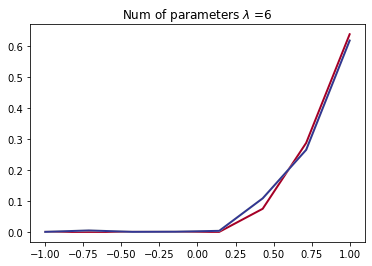

In [65]:
fig,ax=plt.subplots()
colors=plt.cm.RdYlBu(np.linspace(0,1,len(wick.angles)))
s=[]
for j,i in enumerate(wick.angles[-10:]):
    state=wick.get_final_state(i)
    x=np.linspace(-1,1,2**n)
    ax.plot(x,state*state.conj(),label=f"$|\phi(\lambda_{j})>$",lw=2,c=colors[j])
    s.append(state*state.conj())
ax.set_title(f"Num of parameters $\lambda$ ={wick.num_parameters}")
# ax.legend()
plt.show()

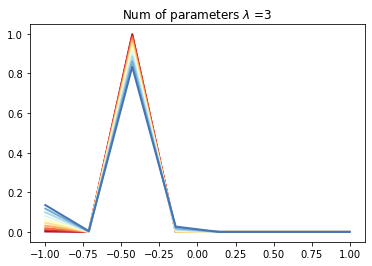

In [398]:
fig,ax=plt.subplots()
colors=plt.cm.RdYlBu(np.linspace(0,1,len(wick.angles)))
s=[]
for j,i in enumerate(wick.angles[-10:]):
    state=wick.get_final_state(i)
    x=np.linspace(-1,1,2**n)
    ax.plot(x,state*state.conj(),label=f"$|\phi(\lambda_{j})>$",lw=2,c=colors[j])
    s.append(state*state.conj())
ax.set_title(f"Num of parameters $\lambda$ ={wick.num_parameters}")
# ax.legend()
plt.show()

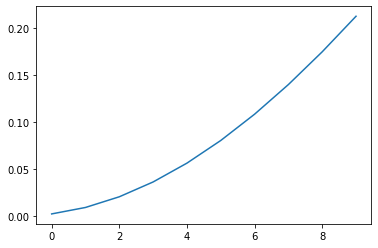

In [204]:
plt.plot(np.asarray([i[:3] for i in np.asarray(s[-10:])]).sum(axis=1))

In [231]:
s=np.asarray(s)
V=np.zeros(s.shape)
k=.01
dx=1
dt=.1
for j in range(2**n):
     for i in range(10):
         V[i,j]=np.exp(-1/2*(k-1)*(i-1)*dx/2-1/4*(k+1)**2 *(j-1)*dt)*s[i,j]

In [360]:
circ_params_wo_meassure=wick.circuit_aij[1][1].copy()
circ_params_wo_meassure.measure(wick.anc,wick.meassure)
values = {i: wick.angles[4][j] for j, i in enumerate(
    circ_params_wo_meassure.parameters)}
circ_params_wo_meassure.assign_parameters(values, inplace=True)
simulator = Aer.get_backend('qasm_simulator')
result = execute(circ_params_wo_meassure, simulator).result()
# statevector = result.get_statevector(circ_params_wo_meassure)
result.get_counts()

{'0': 1024}

In [359]:
circ_params_wo_meassure=wick.circuit_aij[1][1].copy()
values = {i: wick.angles[4][j] for j, i in enumerate(
circ_params_wo_meassure.parameters)}
circ_params_wo_meassure.assign_parameters(values, inplace=True)
simulator = Aer.get_backend('statevector_simulator')
result = execute(circ_params_wo_meassure, simulator).result()
statevector = result.get_statevector(circ_params_wo_meassure)
temp = statevector*statevector.conj()
p_1 = np.real(temp[int(len(temp)/2):].sum())
results = {'1': p_1, '0': 1-p_1}
print(results)

{'1': 5.853085058116413e-33, '0': 1.0}


In [361]:
wick.ham_pauli

{'IIX': 0.5,
 'IXX': 0.25,
 'IYY': 0.25,
 'IZZ': 0.25,
 'XXX': 0.125,
 'XYY': -0.125,
 'YXY': 0.125,
 'YYX': 0.125,
 'ZIZ': 0.25,
 'ZZI': 0.25}

array([[ 0.75,  0.5 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.5 , -0.25,  0.5 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.5 , -0.25,  0.5 ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.5 , -0.25,  0.5 ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.5 , -0.25,  0.5 ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.5 , -0.25,  0.5 ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.5 , -0.25,  0.5 ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.5 ,  0.75]])

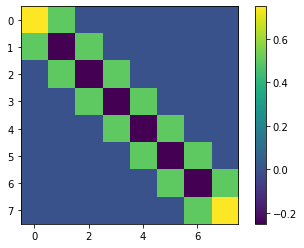

In [377]:
h=np.sum([Pauli.from_label(i).to_matrix()*wick.ham_pauli[i] for i in wick.ham_pauli],axis=0)
plt.imshow(np.real(h))
plt.colorbar()
np.real(h)

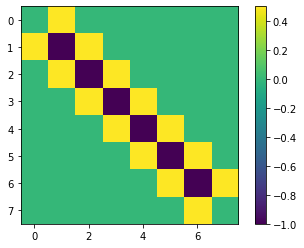

In [378]:
h1=get_diff_mat(2**wick.n, wick.a, wick.b,
                               wick.dx, wick.boundary)
plt.imshow(h1)
plt.colorbar()

# Testing Quantum pricing now

In [8]:
n=3
N=2**n

r = 0 # riskless interest rate
sigma = 0.18 # annual stock volatility
k = 25 # strike price in dollars

# uniform mesh in s
s_init = 0.5
s_end = 2*k 
h = float(s_end - s_init) / N # step-size

# arrange grid in s, with N+1 equally spaced nodes
s = np.zeros(N+1)
s = np.linspace(s_init, s_end, num=N+1, endpoint=True)
s[0] = s_init


D = 1 # In Black-Scholes we have:
      # D = ( 0.5 * (sigma**2) * (s**2) ),
C = 0 # C = ( r * s )


u=np.zeros(N)
for j in range(0, N):
    if (s[j] - k) <= 0: # s[j] - k, for a Call-Option // OR:  (k - s[j]) for a PUT-Option
       u[j] = 0
    elif (s[j] - k) > 0: 
        u[j] = s[j] - k

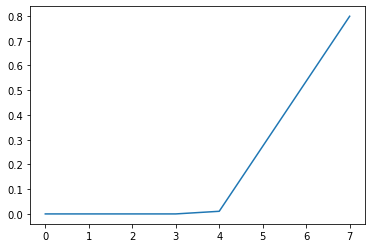

In [11]:
u/=np.linalg.norm(u)
plt.plot(u)

In [26]:
from wick import wick as wick_class

n=4
depth=2
wick=wick_class(n,seed=5,depth=depth,boundary=90,a=1)
print("working opt angles")
wick.get_initial_angles(maxiter=2000,method="COBYLA")
print(wick.initial_closeness)

working opt angles
0.007309163226563387


In [1]:
state=wick.get_final_state(wick.angles[0])

x=np.linspace(-1,1,2**n)
fig,ax=plt.subplots()
ax.plot(x,wick.initial*wick.initial.conj(),c="k",label="$|\psi(t_0)>$",marker="o")
ax.plot(x,state*state.conj(),c="r",label="$|\phi(\lambda_0)>$",lw=2)
ax.set_title(f"Num of parameters $\lambda$ ={wick.num_parameters}")
ax.legend()
plt.show()

NameError: name 'wick' is not defined

In [5]:
import numpy as np
np.angle(1j*1)

1.5707963267948966